<a href="https://colab.research.google.com/github/viranjan/my_MSDS_Repo/blob/main/MSDS458_Assignment_04_20210821_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 4

### Analyze IMDB Movie Review Data Set <br>

Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.<br> 

For more information, please refer to the link http://ai.stanford.edu/~amaas/data/sentiment/<br> 

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.IMDBReviews - https://www.tensorflow.org/datasets/catalog/imdb_reviews#:~:text=tfds.text.IMDBReviews

Download size: 80.23 MiB


## Import packages 

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [ ]:
#tf.get_logger().setLevel('INFO')

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Create a Helper Function to Plot Graphs:

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.6.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.6.0


### Mount Google Drive to Colab Environment

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

###  TensorFlow Datasets Information<br>
<div class="alert alert-block alert-info">
    <b> IMDBReviews</b><br>
    See https://www.tensorflow.org/datasets/catalog/imdb_reviews
    </div>

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [ ]:
#register  IMDBReviews so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=IMDBReviews

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('IMDBReviews', with_info=True,  split=ri, as_supervised=True)

2021-08-27 09:45:30.328063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 09:45:30.972763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 09:45:30.973651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I0827 09:45:30.974689 140073529972608 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
IMDBReviews
I0827 09:45:30.975233 140073529972608 dataset_builder.py:811] No config specified, defaulting to first: imdb_reviews/plain_text
2021-08-27 09:45:30.982977: I tensorflow/core/platform/cloud/google_auth_provider.cc:180

###  Exploratory Analysis IMDBReviews Subset

**Get information about the ag_news_subset dataset. We combined the training and test data for a total of 127,600 news articles.**

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [ ]:
tfds.as_dataframe(dataset_all.take(10),info)

,label,text
0,0 (neg),"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
1,0 (neg),"I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all."
2,0 (neg),"Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust."
3,1 (pos),"This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received."
4,1 (pos),"As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female libido. When men are around they want to be pursued, but when no ""men"" are around, they become the pursuers of a 14 year old boy. And the boy becomes a man really fast (we should all be so lucky at this age!). He then gets up the courage to pursue his true love."
5,1 (pos),"This is a film which should be seen by anybody interested in, effected by, or suffering from an eating disorder. It is an amazingly accurate and sensitive portrayal of bulimia in a teenage girl, its causes and its symptoms. The girl is played by one of the most brilliant young actresses working in cinema today, Alison Lohman, who was later so spectacular in 'Where the Truth Lies'. I would recommend that this film be shown in all schools, as you will never see a better on this subject. Alison Lohman is absolutely outstanding, and one marvels at her ability to convey the anguish of a girl suffering from this compulsive disorder. If barometers tell us the air pressure, Alison Lohman tells us the emotional pressure with the same degree of accuracy. Her emotional range is so precise, each scene could be measured microscopically for its gradations of trauma, on a scale of rising hysteria and desperation which rea

### Review Labels (Categories) 

In [ ]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 2 classes in the dataset.
The class names are ['neg', 'pos']


In [ ]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'neg', 1: 'pos'}

The 25,000 movie reviews are evenly distributed among the 2 categories - Negative and Positive

In [ ]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('neg', 25000), ('pos', 25000)]

We will use the tf.keras.layers.experimental.preprocessing.TextVectorization layer to transform each news article into a "list" of non-negative integers representing the tokens in the news article.

For the purpose of training our models each such "encoding" will have a fixed length corresponding to the news article(s) with the most tokens. Shorter articles will be right-padded with zeros in the encoding. Also to speed up the training process, we will set max_tokens = 1000 so that words not in the vabulary set of top 1000 most common tokes are encoded as 1. But first we set max_tokens = None (which is the default value) in order to get the vocabulary size of the corpus.


In [ ]:
%%time
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None)
encoder.adapt(dataset_all.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

Cause: could not parse the source code of <function <lambda> at 0x7f43f4874e60>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f43f4874e60>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f43f4874e60>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2min 46s, sys: 28.3 s, total: 3min 15s
Wall time: 1min 51s


In [ ]:
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 182738 vocabulary words in the corpus.


There are 182738 vocabulary words in the corpus.

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'with', 'for', 'movie', 'but'],
      dtype='<U72')

Let us get the total number of words in the corpus and the sizes of the news articles

In [ ]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 8min 7s, sys: 58.1 s, total: 9min 5s
Wall time: 7min 34s


In [ ]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 11512672 words in the corpus of 50000 news articles.
Each news article has between 4 and 2469 tokens in it.


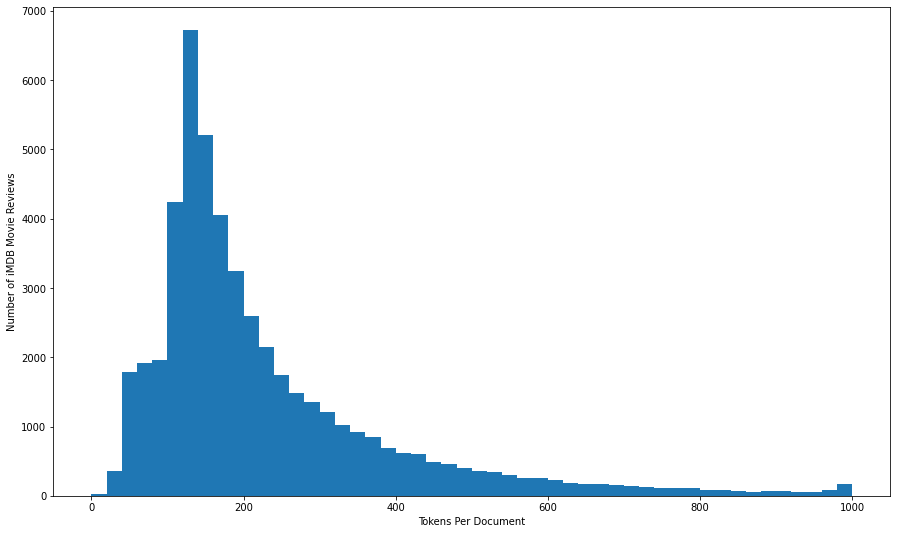

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=50,range = (0,1000))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of iMDB Movie Reviews");

Encode the news articles using the top 1000 most common words in the corpus

In [ ]:
%%time
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_1000.adapt(dataset_all.map(lambda text, label: text))
vocab_1000 = np.array(encoder_1000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7f43a9cce290>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f43a9cce290>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f43a9cce290>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2min 46s, sys: 28 s, total: 3min 14s
Wall time: 2min 22s


The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab_1000[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'with', 'for', 'movie', 'but'],
      dtype='<U14')

In particular, 0 is use for padding, 1 for the unknown words, 2 for the common word, i.e. 'the', etc. Let us look at the same example we encoded previously using the encoder for all the vocabulary words. Note that there are now five 1's denoting words that are not in the top 1000 in frequency.

We encode the same example as before using the new encoder. Note that there are now 5 out of vocabulary words.

In [ ]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_1000(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([  2, 828,   1, 101,   4, 846,   1,  15,   9,   1,  33,   2,   1,
        21,   2,   1])>

In [ ]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_1000  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is in the vocabulary.
"ran" is *not* in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is *not* in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


We want to determine the number of non-vocabulary words in each news articles (denoted by 1s in the encoding)

In [ ]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_1000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 9min 17s, sys: 1min 1s, total: 10min 19s
Wall time: 9min 21s


In [ ]:
print(f"Each movie review has between {min(doc1000_sizes)} and {max(doc1000_sizes)} tokens in it.")

Each movie review has between 4 and 2469 tokens in it.


In [ ]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True) 

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  63,  65,  67,
        100]),
 array([  10,    1,    7,   13,   28,   47,   61,  115,  213,  328,  440,
         579,  881, 1022, 1457, 1634, 1961, 2115, 2405, 2555, 2775, 2728,
        2921, 2819, 2688, 2532, 2476, 2237, 2097, 1760, 1634, 1376, 1172,
         967,  829,  683,  541,  383,  365,  261,  219,  171,  100,   83,
          61,   40,   44,   34,   29,   28,   23,   12,    5,   10,    4,
           4,    3,    1,    2,    3,    3,    1,    1,    1,    1,    1]))

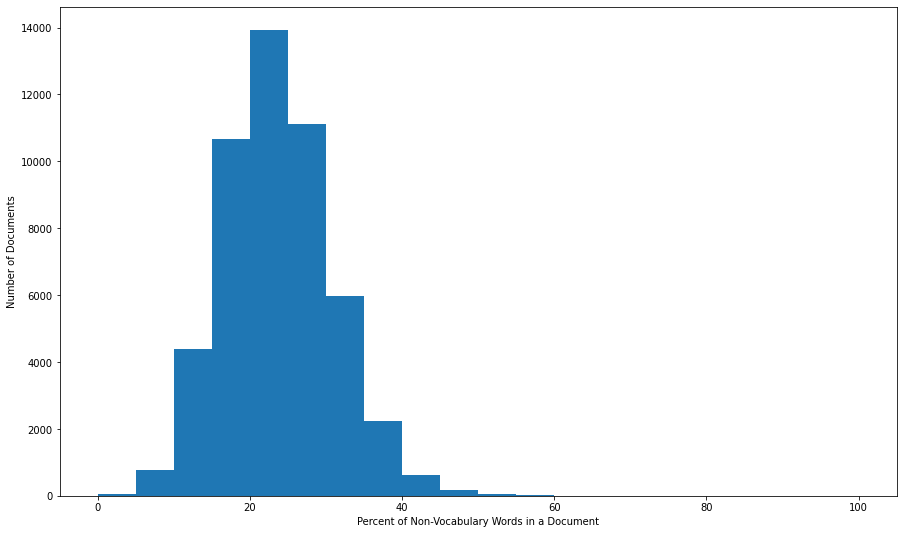

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [ ]:
print(f"There are {count1000} top {len(vocab_1000)} vocabulary words in the corpus.")

There are 8711810 top 1000 vocabulary words in the corpus.


### Preprocessing Data Create Input Pipeline

In [ ]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=IMDBReviews

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('IMDBReviews', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2021-08-27 10:26:32.128784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 10:26:32.138052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 10:26:32.138845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I0827 10:26:32.139790 139799616919424 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
IMDBReviews
I0827 10:26:32.140259 139799616919424 dataset_builder.py:811] No config specified, defaulting to first: imdb_reviews/plain_text
I0827 10:26:32.140828 139799616919424 dataset_info.py:361] Load dataset info from /root/

In [ ]:
####  Dataset Splits (Training, Test, Validation)
#### .8934 Training, .0470 Test, .0596 Validation

In [ ]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(23750, 1250, 25000)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [ ]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('neg', 11912), ('pos', 11838)]

Review Example with Interger Label(text, label pairs):

Review Example with Interger Label Encoded Classification(text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
class:  neg


#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
train_dataset_e1 = train_dataset
validation_dataset_e1 = validation_dataset
test_dataset_e1 = test_dataset

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Claustrophobic camera angles that do not help the movie: Too long face only shots where you most of the time get the feeling that the lower half of the film is missing (that the screen is cut off), because there seems to be important actions going on, but you cannot see them. There is anyway already too much confusion in the movie, so these viewing angles make it worse and do not contribute to artful visuals. <br /><br />I like artfully made movies and unconventional camera work. I can handle deep and slow movies. But this one is trying too hard to be something artful and fails in my opinion painfully.<br /><br />Nothing to get attached to, to any of the characters, because they are not worked out well enough. To work out characters more is needed, than just minute long face shots, at least with this set of script+director+actors.<br /><br />I wonder whether some of the not so good acting is due to the script and director or due to the actors. <br /><br />I will stay away fr

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b'I heard tell that Madonna was briefly considered for the Catherine Tremell role. Compared to Sharon Stone, Madonna is too coarse and BAUERISCH. She\'s not even close. <br /><br />EVIL INCARNATE: Sharon Stone is a bit long in the tooth, the ameliorative effects of modern chemistry and surgery notwithstanding. However, she artfully treats us to a frightening personification of evil beyond redemption. In the obligatory sex scene, she projects pure, crystalline lust. Especially her hooded, luminous eyes and a face flat with pleasure. Thanks to brilliant use of lighting and other stage techniques, the harsh lines of age are only occasionally manifest. Rather, she seems to have a slight golden glow (YES, YEATS). <br /><br />The locations gave us a view of London that is a welcome departure from the usual Londonscapes .The Catherine character is so powerful and menacing that I thank my lucky stars that our paths never crossed. I wouldn\'t have had a chance.<br /><br />THE ORIGINAL 

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Here are the 20 least frequent words.

In [ ]:
vocab[-20:]

array(['portrayed', 'jane', 'inside', 'mark', 'dumb', 'unlike', 'missing',
       'gay', 'fighting', 'air', 'married', 'fantasy', 'pay', 'fails',
       'match', 'fire', 'fairly', 'ideas', 'political', 'sadly'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2,   1,  24, ...,   0,   0,   0],
       [ 30, 164,  87, ...,   0,   0,   0],
       [  1,   3,   1, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"The complaints are valid, to me the biggest problem is that this soap opera is too aimed for women. I am okay with these night time soaps, like Grey's Anatomy, or Ugly Betty, or West Wing, because there are stories that are interesting even with the given that they will never end. However, when the idea parallels the daytime soaps aimed at just putting hunky men (Taye Diggs, Tim Daly, and Chris Lowell) into sexual tension and romps, and numerous ridiculous difficult situations in a so-called little hospital, it seems like General Hospital...or a female counterpart to Baywatch. That was what men wanted and they had it, so if this is what women want so be it, but the idea that this is a high brow show (or something men will watch) is unrealistic."
Round-trip:  the [UNK] are [UNK] to me the [UNK] problem is that this [UNK] [UNK] is too [UNK] for women i am okay with these night time [UNK] like [UNK] [UNK] or [UNK] [UNK] or [UNK] [UNK] because there are stories that are intere

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

#Experiment C-a: LSTM - Bidirectional 

In [ ]:
num_classes = 2
modelca = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
modelca.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in modelca.layers])

[False, True, True, True, True]


## Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start = datetime.datetime.now()
historyca = modelca.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
Modelca_Train_Time = datetime.datetime.now()-start
print(Modelca_Train_Time)

Epoch 1/200
372/372 [==============================] - 42s 78ms/step - loss: 0.6573 - accuracy: 0.6019 - val_loss: 0.4903 - val_accuracy: 0.7576
Epoch 2/200
372/372 [==============================] - 28s 73ms/step - loss: 0.4438 - accuracy: 0.8008 - val_loss: 0.4349 - val_accuracy: 0.8296
Epoch 3/200
372/372 [==============================] - 28s 73ms/step - loss: 0.3629 - accuracy: 0.8460 - val_loss: 0.3466 - val_accuracy: 0.8576
Epoch 4/200
372/372 [==============================] - 28s 73ms/step - loss: 0.3307 - accuracy: 0.8622 - val_loss: 0.3275 - val_accuracy: 0.8688
Epoch 5/200
372/372 [==============================] - 28s 73ms/step - loss: 0.3169 - accuracy: 0.8668 - val_loss: 0.3182 - val_accuracy: 0.8624
Epoch 6/200
372/372 [==============================] - 28s 73ms/step - loss: 0.3085 - accuracy: 0.8720 - val_loss: 0.3192 - val_accuracy: 0.8720
Epoch 7/200
372/372 [==============================] - 28s 73ms/step - loss: 0.3057 - accuracy: 0.8732 - val_loss: 0.3139 - val_ac

In [ ]:
test_loss, test_acc = modelca.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 16s 40ms/step - loss: 0.3184 - accuracy: 0.8627
Test Loss: 0.3183911442756653
Test Accuracy: 0.8626800179481506


## Plotting Performance Metrics - Single Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dictca = historyca.history
history_dictca.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_dfca=pd.DataFrame(history_dictca)
history_dfca.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.657,0.602,0.490,0.758
1,0.444,0.801,0.435,0.830
2,0.363,0.846,0.347,0.858
3,0.331,0.862,0.327,0.869
4,0.317,0.867,0.318,0.862
5,0.308,0.872,0.319,0.872
6,0.306,0.873,0.314,0.868
7,0.300,0.875,0.322,0.860


In [ ]:
losses = historyca.history['loss']
accs = historyca.history['accuracy']
val_losses = historyca.history['val_loss']
val_accs = historyca.history['val_accuracy']
epochs = len(losses)

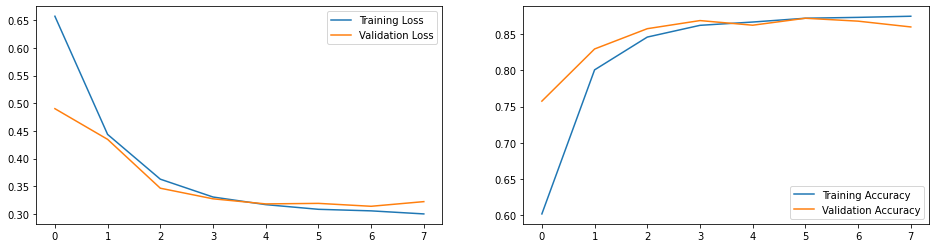

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
modelca.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 138,434
Trainable params: 138,434
Non-trainable params: 0
_________________________________________________________________


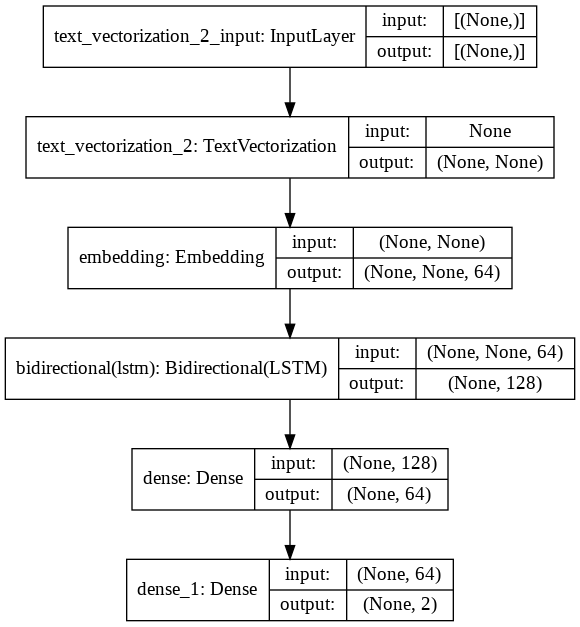

In [ ]:
keras.utils.plot_model(modelca, "BiDirectionalLSTM.png", show_shapes=True)

#Experiment C-b: LSTM - Bidirectional - 2 Layers - 50% dropout

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [ ]:
modelcb = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
modelcb.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historycb = modelcb.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                   # ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
Modelcb_Train_Time = datetime.datetime.now()-start
print(Modelcb_Train_Time)

Epoch 1/200
372/372 [==============================] - 64s 139ms/step - loss: 0.4665 - accuracy: 0.7638 - val_loss: 0.3724 - val_accuracy: 0.8328
Epoch 2/200
372/372 [==============================] - 48s 128ms/step - loss: 0.3580 - accuracy: 0.8463 - val_loss: 0.3386 - val_accuracy: 0.8552
Epoch 3/200
372/372 [==============================] - 48s 129ms/step - loss: 0.3257 - accuracy: 0.8620 - val_loss: 0.3326 - val_accuracy: 0.8536
Epoch 4/200
372/372 [==============================] - 49s 130ms/step - loss: 0.3014 - accuracy: 0.8724 - val_loss: 0.3335 - val_accuracy: 0.8552
0:03:29.546681


In [ ]:
test_loss, test_acc = modelcb.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 26s 66ms/step - loss: 0.3303 - accuracy: 0.8582
Test Loss: 0.33025529980659485
Test Accuracy: 0.858240008354187


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dictcb = historycb.history
history_dictcb.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
historycb_df=pd.DataFrame(history_dictcb)
historycb_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.466,0.764,0.372,0.833
1,0.358,0.846,0.339,0.855
2,0.326,0.862,0.333,0.854
3,0.301,0.872,0.334,0.855


In [ ]:
losses = historycb.history['loss']
accs = historycb.history['accuracy']
val_losses = historycb.history['val_loss']
val_accs = historycb.history['val_accuracy']
epochs = len(losses)

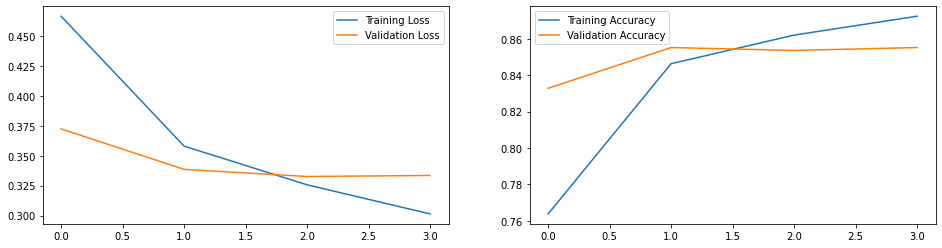

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = modelcb.predict(test_dataset)

In [ ]:
preds.shape

(25000, 2)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['Positive','Negative']).T  #World','Sports','Business','Sci/Tech'
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Positive,73.40%,4.14%,95.66%,87.62%,1.12%,1.62%,0.43%,0.88%,53.01%,12.62%,95.65%,57.38%,59.83%,93.03%,6.37%
Negative,26.60%,95.86%,4.34%,12.38%,98.88%,98.38%,99.57%,99.12%,46.99%,87.38%,4.35%,42.62%,40.17%,6.97%,93.63%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
modelcb.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

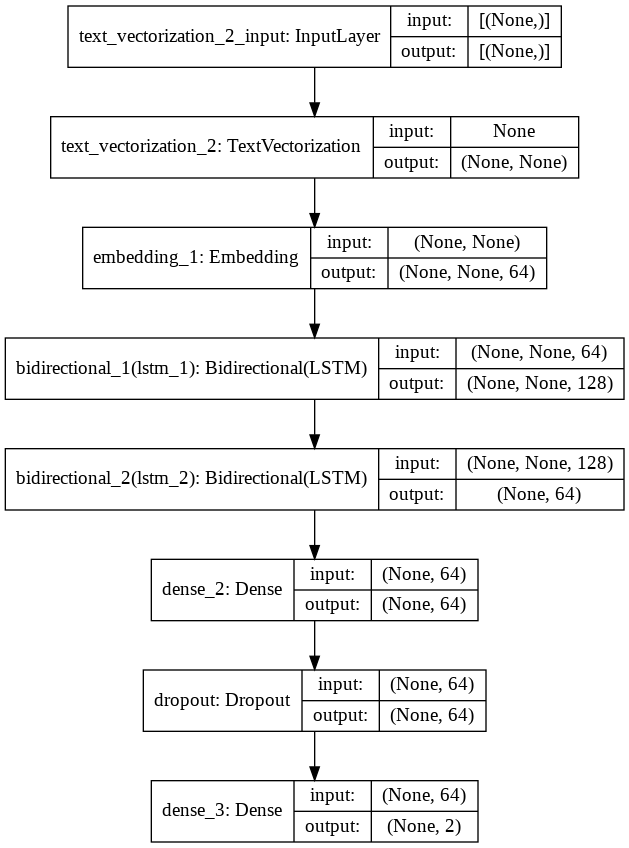

In [ ]:
keras.utils.plot_model(modelcb, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

#Experiment C-c: LSTM - Unidirectional  - 1 Layer

In [ ]:
modelcc = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.LSTM(64)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.2)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
modelcc.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historycc = modelcc.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    #,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                    )
Modelcc_Train_Time = datetime.datetime.now()-start
print(Modelcc_Train_Time)

Epoch 1/200
372/372 [==============================] - 20s 43ms/step - loss: 0.5625 - accuracy: 0.6991 - val_loss: 0.3742 - val_accuracy: 0.8368
Epoch 2/200
372/372 [==============================] - 16s 41ms/step - loss: 0.4608 - accuracy: 0.7847 - val_loss: 0.5406 - val_accuracy: 0.7152
Epoch 3/200
372/372 [==============================] - 16s 41ms/step - loss: 0.3910 - accuracy: 0.8327 - val_loss: 0.3512 - val_accuracy: 0.8520
Epoch 4/200
372/372 [==============================] - 16s 41ms/step - loss: 0.3433 - accuracy: 0.8576 - val_loss: 0.3433 - val_accuracy: 0.8504
Epoch 5/200
372/372 [==============================] - 16s 41ms/step - loss: 0.3198 - accuracy: 0.8679 - val_loss: 0.3286 - val_accuracy: 0.8584
Epoch 6/200
372/372 [==============================] - 16s 41ms/step - loss: 0.3029 - accuracy: 0.8743 - val_loss: 0.3352 - val_accuracy: 0.8552
Epoch 7/200
372/372 [==============================] - 16s 41ms/step - loss: 0.2941 - accuracy: 0.8781 - val_loss: 0.3639 - val_ac

In [ ]:
test_loss, test_acc = modelcc.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 10s 24ms/step - loss: 0.3523 - accuracy: 0.8501
Test Loss: 0.352283239364624
Test Accuracy: 0.8501200079917908


In [ ]:
history_dictcc = historycc.history
history_dictcc.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
historycc_df=pd.DataFrame(history_dictcc)
historycc_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.343,0.858,0.343,0.850
4,0.320,0.868,0.329,0.858
5,0.303,0.874,0.335,0.855
6,0.294,0.878,0.364,0.840
7,0.289,0.879,0.349,0.854


In [ ]:
modelcc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 101,314
Trainable params: 101,314
Non-trainable params: 0
________________________________________________

#Experiment C-d: LSTM - Bidirectional with Regularization

In [ ]:
num_classes = 2
modelcd = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()) ,output_dim=64 ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
modelcd.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historycd = modelcd.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
Modelcd_Train_Time = datetime.datetime.now()-start
print(Modelcd_Train_Time)

Epoch 1/200
372/372 [==============================] - 35s 78ms/step - loss: 0.6266 - accuracy: 0.6414 - val_loss: 0.4369 - val_accuracy: 0.8000
Epoch 2/200
372/372 [==============================] - 28s 73ms/step - loss: 0.3873 - accuracy: 0.8318 - val_loss: 0.3495 - val_accuracy: 0.8512
Epoch 3/200
372/372 [==============================] - 28s 73ms/step - loss: 0.3354 - accuracy: 0.8587 - val_loss: 0.3333 - val_accuracy: 0.8616
Epoch 4/200
372/372 [==============================] - 28s 73ms/step - loss: 0.3176 - accuracy: 0.8665 - val_loss: 0.3223 - val_accuracy: 0.8680
Epoch 5/200
372/372 [==============================] - 28s 73ms/step - loss: 0.3102 - accuracy: 0.8702 - val_loss: 0.3136 - val_accuracy: 0.8712
Epoch 6/200
372/372 [==============================] - 27s 72ms/step - loss: 0.3043 - accuracy: 0.8740 - val_loss: 0.3191 - val_accuracy: 0.8616
Epoch 7/200
372/372 [==============================] - 28s 73ms/step - loss: 0.3011 - accuracy: 0.8771 - val_loss: 0.3153 - val_ac

In [ ]:
test_loss, test_acc = modelcd.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 16s 40ms/step - loss: 0.3233 - accuracy: 0.8584
Test Loss: 0.3232964873313904
Test Accuracy: 0.8583999872207642


In [ ]:
history_dictcd = historycd.history
history_dictcd.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_dfcd = pd.DataFrame(history_dictcd)
history_dfcd.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.627,0.641,0.437,0.800
1,0.387,0.832,0.350,0.851
2,0.335,0.859,0.333,0.862
3,0.318,0.867,0.322,0.868
4,0.310,0.870,0.314,0.871
5,0.304,0.874,0.319,0.862
6,0.301,0.877,0.315,0.866


In [ ]:
modelcd.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                

#Experiment C-e: LSTM - Unidirectional without Regularization

In [ ]:
modelce = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.LSTM(64)
                              ,tf.keras.layers.Dense(32, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
modelce.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historyce = modelce.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    #,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
Modelce_Train_Time = datetime.datetime.now()-start
print(Modelce_Train_Time)

Epoch 1/200
372/372 [==============================] - 21s 44ms/step - loss: 0.5556 - accuracy: 0.6972 - val_loss: 0.4135 - val_accuracy: 0.8136
Epoch 2/200
372/372 [==============================] - 16s 41ms/step - loss: 0.3886 - accuracy: 0.8326 - val_loss: 0.3435 - val_accuracy: 0.8512
Epoch 3/200
372/372 [==============================] - 16s 41ms/step - loss: 0.3357 - accuracy: 0.8602 - val_loss: 0.3557 - val_accuracy: 0.8480
Epoch 4/200
372/372 [==============================] - 16s 41ms/step - loss: 0.3191 - accuracy: 0.8680 - val_loss: 0.3325 - val_accuracy: 0.8600
Epoch 5/200
372/372 [==============================] - 16s 42ms/step - loss: 0.3041 - accuracy: 0.8746 - val_loss: 0.3297 - val_accuracy: 0.8584
Epoch 6/200
372/372 [==============================] - 16s 41ms/step - loss: 0.2984 - accuracy: 0.8759 - val_loss: 0.3628 - val_accuracy: 0.8488
0:01:54.184782


In [ ]:
test_loss, test_acc = modelce.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 10s 25ms/step - loss: 0.3512 - accuracy: 0.8496
Test Loss: 0.3512252867221832
Test Accuracy: 0.8496000170707703


In [ ]:
history_dictce = historyce.history
history_dictce.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
historyce_df=pd.DataFrame(history_dictce)
historyce_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,0.389,0.833,0.343,0.851
2,0.336,0.860,0.356,0.848
3,0.319,0.868,0.333,0.860
4,0.304,0.875,0.330,0.858
5,0.298,0.876,0.363,0.849


In [ ]:
modelce.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 66        
Total params: 99,170
Trainable params: 99,170
Non-trainable params: 0
_________________________________________________________________


#Experiment C-f: LSTM - Bidirectional  - 2 Layer without Regularization

In [ ]:
num_classes = 2

modelcf = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              #,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
modelcf.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historycf = modelcf.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
Modelcf_Train_Time = datetime.datetime.now()-start
print(Modelcf_Train_Time)

Epoch 1/200
372/372 [==============================] - 64s 137ms/step - loss: 0.5850 - accuracy: 0.6745 - val_loss: 0.4121 - val_accuracy: 0.8072
Epoch 2/200
372/372 [==============================] - 48s 127ms/step - loss: 0.3555 - accuracy: 0.8463 - val_loss: 0.3553 - val_accuracy: 0.8408
Epoch 3/200
372/372 [==============================] - 48s 127ms/step - loss: 0.3202 - accuracy: 0.8662 - val_loss: 0.3139 - val_accuracy: 0.8640
Epoch 4/200
372/372 [==============================] - 48s 128ms/step - loss: 0.3140 - accuracy: 0.8680 - val_loss: 0.3082 - val_accuracy: 0.8672
Epoch 5/200
372/372 [==============================] - 48s 129ms/step - loss: 0.3028 - accuracy: 0.8741 - val_loss: 0.3208 - val_accuracy: 0.8640
Epoch 6/200
372/372 [==============================] - 48s 128ms/step - loss: 0.2976 - accuracy: 0.8769 - val_loss: 0.3286 - val_accuracy: 0.8560
0:06:40.749918


In [ ]:
test_loss, test_acc = modelcf.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 26s 66ms/step - loss: 0.3250 - accuracy: 0.8575
Test Loss: 0.3249647915363312
Test Accuracy: 0.8575199842453003


In [ ]:
history_dictcf = historycf.history
history_dictcf.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_dfcf=pd.DataFrame(history_dictcf)
history_dfcf.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.585,0.674,0.412,0.807
1,0.355,0.846,0.355,0.841
2,0.320,0.866,0.314,0.864
3,0.314,0.868,0.308,0.867
4,0.303,0.874,0.321,0.864
5,0.298,0.877,0.329,0.856


In [ ]:
modelcf.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 130       
Total params: 175,554
Trainable params: 175,554
Non-trainable params: 0
________________________________________________

## Experiment C-g: LSTM - Bidirectional - 2 Layer with Dropout and L1 Regularization

In [ ]:
num_classes = 2

modelcg = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.20)
                              ,tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001))
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
modelcg.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historycg = modelcg.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
Modelcg_Train_Time = datetime.datetime.now()-start
print(Modelcg_Train_Time)

Epoch 1/200
372/372 [==============================] - 64s 137ms/step - loss: 0.6486 - accuracy: 0.6393 - val_loss: 0.4338 - val_accuracy: 0.8280
Epoch 2/200
372/372 [==============================] - 48s 127ms/step - loss: 0.3967 - accuracy: 0.8403 - val_loss: 0.3586 - val_accuracy: 0.8504
Epoch 3/200
372/372 [==============================] - 48s 128ms/step - loss: 0.3510 - accuracy: 0.8648 - val_loss: 0.3449 - val_accuracy: 0.8616
Epoch 4/200
372/372 [==============================] - 48s 128ms/step - loss: 0.3319 - accuracy: 0.8715 - val_loss: 0.3474 - val_accuracy: 0.8664
Epoch 5/200
372/372 [==============================] - 48s 127ms/step - loss: 0.3200 - accuracy: 0.8762 - val_loss: 0.3311 - val_accuracy: 0.8672
Epoch 6/200
372/372 [==============================] - 47s 126ms/step - loss: 0.3155 - accuracy: 0.8755 - val_loss: 0.3301 - val_accuracy: 0.8664
Epoch 7/200
372/372 [==============================] - 47s 126ms/step - loss: 0.3103 - accuracy: 0.8772 - val_loss: 0.3321 -

In [ ]:
test_loss, test_acc = modelcg.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 25s 65ms/step - loss: 0.3307 - accuracy: 0.8619
Test Loss: 0.3306925892829895
Test Accuracy: 0.8619199991226196


In [ ]:
history_dictcg = historycg.history
history_dictcg.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_dfcg = pd.DataFrame(history_dictcg)
history_dfcg.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.649,0.639,0.434,0.828
1,0.397,0.840,0.359,0.850
2,0.351,0.865,0.345,0.862
3,0.332,0.871,0.347,0.866
4,0.320,0.876,0.331,0.867
5,0.315,0.875,0.330,0.866
6,0.310,0.877,0.332,0.868
7,0.302,0.881,0.390,0.826
8,0.299,0.883,0.331,0.865


In [ ]:
modelcg.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)               

## Experiment C-h: LSTM - Bidirectional - 2 Layer with Dropout and L1 L2 Regularization

In [ ]:
num_classes = 2

modelch = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.50)
                              ,tf.keras.layers.Dense(62, activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(0.001))
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
modelch.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historych = modelch.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
Modelch_Train_Time = datetime.datetime.now()-start
print(Modelch_Train_Time)

Epoch 1/200
372/372 [==============================] - 189s 448ms/step - loss: 1.0076 - accuracy: 0.6181 - val_loss: 0.7815 - val_accuracy: 0.7688
Epoch 2/200
372/372 [==============================] - 160s 428ms/step - loss: 0.6623 - accuracy: 0.8317 - val_loss: 0.5767 - val_accuracy: 0.8488
Epoch 3/200
372/372 [==============================] - 156s 417ms/step - loss: 0.5332 - accuracy: 0.8604 - val_loss: 0.4786 - val_accuracy: 0.8648
Epoch 4/200
372/372 [==============================] - 159s 425ms/step - loss: 0.4582 - accuracy: 0.8680 - val_loss: 0.4273 - val_accuracy: 0.8616
Epoch 5/200
372/372 [==============================] - 156s 416ms/step - loss: 0.4089 - accuracy: 0.8735 - val_loss: 0.3878 - val_accuracy: 0.8704
Epoch 6/200
372/372 [==============================] - 157s 419ms/step - loss: 0.3780 - accuracy: 0.8755 - val_loss: 0.3883 - val_accuracy: 0.8640
Epoch 7/200
372/372 [==============================] - 156s 416ms/step - loss: 0.3577 - accuracy: 0.8775 - val_loss: 0

In [ ]:
test_loss, test_acc = modelch.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 82s 211ms/step - loss: 0.3602 - accuracy: 0.8654
Test Loss: 0.36019179224967957
Test Accuracy: 0.8654400110244751


In [ ]:
history_dictch = historych.history
history_dictch.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_dfch = pd.DataFrame(history_dictch)
history_dfch.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,1.008,0.618,0.782,0.769
1,0.662,0.832,0.577,0.849
2,0.533,0.860,0.479,0.865
3,0.458,0.868,0.427,0.862
4,0.409,0.873,0.388,0.870
5,0.378,0.875,0.388,0.864
6,0.358,0.878,0.360,0.864


In [ ]:
modelch.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 62)                4

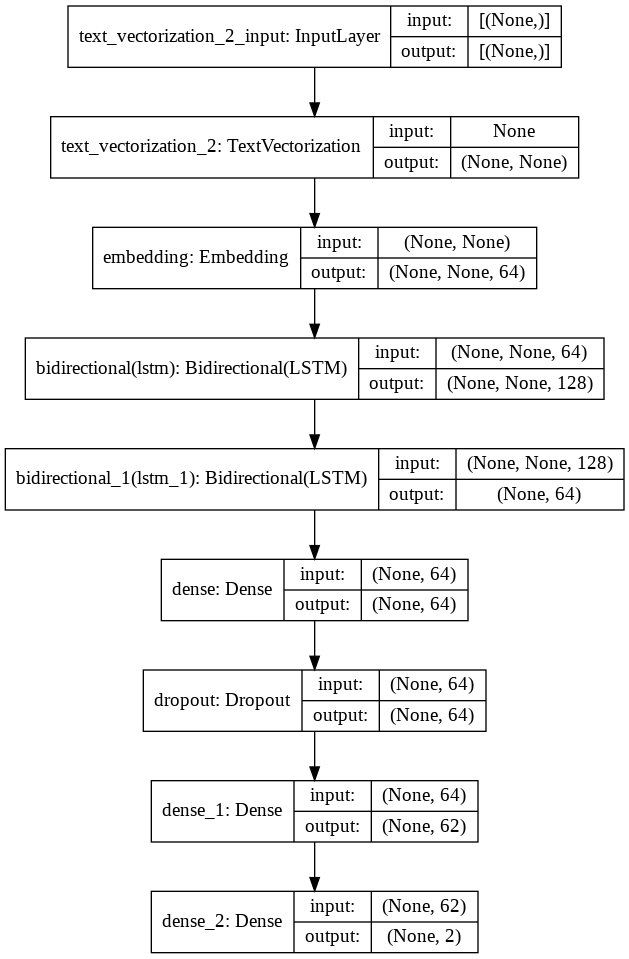

In [ ]:
keras.utils.plot_model(modelch, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dictch = historych.history
history_dictch.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
historych_df=pd.DataFrame(history_dictch)
historych_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
2,0.533,0.860,0.479,0.865
3,0.458,0.868,0.427,0.862
4,0.409,0.873,0.388,0.870
5,0.378,0.875,0.388,0.864
6,0.358,0.878,0.360,0.864


In [ ]:
losses = historych.history['loss']
accs = historych.history['accuracy']
val_losses = historych.history['val_loss']
val_accs = historych.history['val_accuracy']
epochs = len(losses)

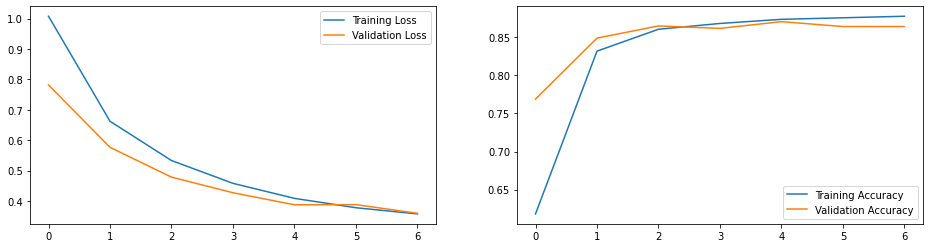

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = modelch.predict(test_dataset)

In [ ]:
preds.shape

(25000, 2)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['Positive','Negative']).T  #World','Sports','Business','Sci/Tech'
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Positive,69.07%,5.85%,95.83%,91.50%,4.27%,3.35%,0.69%,1.11%,13.96%,39.26%,95.60%,76.84%,21.31%,92.77%,19.04%
Negative,30.93%,94.15%,4.17%,8.50%,95.73%,96.65%,99.31%,98.89%,86.04%,60.74%,4.40%,23.16%,78.69%,7.23%,80.96%


In [ ]:
## kernel_regularizer =tf.keras.regularizers.l2( l=0.01)

#=====================================

#Experiment B-a: RNN  - 1 Layer

In [ ]:
modelba = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.SimpleRNN(64)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.2)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
modelba.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historyba = modelba.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    #,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                    )
Modelba_Train_Time = datetime.datetime.now()-start
print(Modelba_Train_Time)

Epoch 1/200
372/372 [==============================] - 434s 1s/step - loss: 0.6611 - accuracy: 0.5744 - val_loss: 0.6654 - val_accuracy: 0.5816
Epoch 2/200
372/372 [==============================] - 434s 1s/step - loss: 0.6580 - accuracy: 0.5944 - val_loss: 0.6350 - val_accuracy: 0.6264
Epoch 3/200
372/372 [==============================] - 433s 1s/step - loss: 0.6226 - accuracy: 0.6433 - val_loss: 0.6185 - val_accuracy: 0.6384
Epoch 4/200
372/372 [==============================] - 435s 1s/step - loss: 0.6079 - accuracy: 0.6780 - val_loss: 0.6652 - val_accuracy: 0.5992
Epoch 5/200
372/372 [==============================] - 436s 1s/step - loss: 0.6178 - accuracy: 0.6506 - val_loss: 0.6090 - val_accuracy: 0.6584
Epoch 6/200
372/372 [==============================] - 428s 1s/step - loss: 0.5554 - accuracy: 0.7113 - val_loss: 0.4938 - val_accuracy: 0.7688
Epoch 7/200
372/372 [==============================] - 429s 1s/step - loss: 0.4522 - accuracy: 0.7961 - val_loss: 0.4145 - val_accuracy:

In [ ]:
test_loss, test_acc = modelba.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 35s 90ms/step - loss: 0.4693 - accuracy: 0.8130
Test Loss: 0.46925434470176697
Test Accuracy: 0.8129600286483765


In [ ]:
history_dictba = historyba.history
history_dictba.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
historyba_df=pd.DataFrame(history_dictba)
historyba_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
6,0.452,0.796,0.414,0.826
7,0.398,0.829,0.401,0.829
8,0.406,0.829,0.447,0.806
9,0.387,0.833,0.608,0.666
10,0.442,0.803,0.505,0.810


In [ ]:
modelba.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 130       
Total params: 76,546
Trainable params: 76,546
Non-trainable params: 0
__________________________________________________

## Experiment B-c: RNN - 1 Layer

In [ ]:
modelbc = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.SimpleRNN(64)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.20)
                              ,tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.001))
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
modelbc.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historybc = modelbc.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    #,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                    )
Modelbc_Train_Time = datetime.datetime.now()-start
print(Modelbc_Train_Time)

Epoch 1/200
372/372 [==============================] - 436s 1s/step - loss: 0.8458 - accuracy: 0.5101 - val_loss: 0.7263 - val_accuracy: 0.5424
Epoch 2/200
372/372 [==============================] - 435s 1s/step - loss: 0.7134 - accuracy: 0.5046 - val_loss: 0.7005 - val_accuracy: 0.5384
Epoch 3/200
372/372 [==============================] - 430s 1s/step - loss: 0.6984 - accuracy: 0.5109 - val_loss: 0.6962 - val_accuracy: 0.4856
Epoch 4/200
372/372 [==============================] - 433s 1s/step - loss: 0.6949 - accuracy: 0.5105 - val_loss: 0.6934 - val_accuracy: 0.5384
0:29:01.009529


In [ ]:
test_loss, test_acc = modelbc.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 35s 89ms/step - loss: 0.6949 - accuracy: 0.5083
Test Loss: 0.6948842406272888
Test Accuracy: 0.5083199739456177


In [ ]:
history_dictbc = historybc.history
history_dictbc.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
historybc_df=pd.DataFrame(history_dictbc)
historybc_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.846,0.510,0.726,0.542
1,0.713,0.505,0.700,0.538
2,0.698,0.511,0.696,0.486
3,0.695,0.511,0.693,0.538


In [ ]:
modelbc.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 2)               

#Experiment B-b: RNN  - 2 Layer - Unidirectional without Regularization

In [ ]:
modelbb = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.SimpleRNN(64)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
modelbb.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historybb = modelbb.fit(train_dataset
                    ,epochs=100
                    ,validation_data=validation_dataset
                    #,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
Modelbb_Train_Time = datetime.datetime.now()-start
print(Modelbb_Train_Time)

Epoch 1/100
372/372 [==============================] - 436s 1s/step - loss: 0.6889 - accuracy: 0.5413 - val_loss: 0.6733 - val_accuracy: 0.5832
Epoch 2/100
372/372 [==============================] - 434s 1s/step - loss: 0.6397 - accuracy: 0.6241 - val_loss: 0.6158 - val_accuracy: 0.6424
Epoch 3/100
372/372 [==============================] - 439s 1s/step - loss: 0.5707 - accuracy: 0.6990 - val_loss: 0.5013 - val_accuracy: 0.7648
Epoch 4/100
372/372 [==============================] - 436s 1s/step - loss: 0.5773 - accuracy: 0.6891 - val_loss: 0.5755 - val_accuracy: 0.6920
Epoch 5/100
372/372 [==============================] - 437s 1s/step - loss: 0.6030 - accuracy: 0.6624 - val_loss: 0.6402 - val_accuracy: 0.6328
0:36:39.156141


In [ ]:
test_loss, test_acc = modelbb.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 35s 90ms/step - loss: 0.4693 - accuracy: 0.8130
Test Loss: 0.46925434470176697
Test Accuracy: 0.8129600286483765


In [ ]:
history_dictbb = historybb.history
history_dictbb.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
historybb_df=pd.DataFrame(history_dictbb)
historybb_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.689,0.541,0.673,0.583
1,0.640,0.624,0.616,0.642
2,0.571,0.699,0.501,0.765
3,0.577,0.689,0.576,0.692
4,0.603,0.662,0.640,0.633


In [ ]:
modelbb.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 130       
Total params: 76,546
Trainable params: 76,546
Non-trainable params: 0
__________________________________________________

===================================================

# Experiment D-a - Conv1D

In [ ]:
modelda = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True) 
                              ,tf.keras.layers.Conv1D(64, 5, activation='relu')
                              ,tf.keras.layers.GlobalMaxPooling1D()   #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.2)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
modelda.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historyda = modelda.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
Modelda_Train_Time = datetime.datetime.now()-start
print(Modelda_Train_Time)

Epoch 1/200
372/372 [==============================] - 51s 69ms/step - loss: 0.4697 - accuracy: 0.7634 - val_loss: 0.3407 - val_accuracy: 0.8472
Epoch 2/200
372/372 [==============================] - 15s 38ms/step - loss: 0.2905 - accuracy: 0.8791 - val_loss: 0.3119 - val_accuracy: 0.8688
Epoch 3/200
372/372 [==============================] - 13s 33ms/step - loss: 0.2136 - accuracy: 0.9174 - val_loss: 0.3180 - val_accuracy: 0.8680
Epoch 4/200
372/372 [==============================] - 12s 30ms/step - loss: 0.1437 - accuracy: 0.9486 - val_loss: 0.3530 - val_accuracy: 0.8616
0:01:31.738292


In [ ]:
test_loss, test_acc = modelda.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 9s 23ms/step - loss: 0.3423 - accuracy: 0.8668
Test Loss: 0.34230202436447144
Test Accuracy: 0.8667600154876709


In [ ]:
history_dictda = historyda.history
history_dictda.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
historyda_df=pd.DataFrame(history_dictda)
historyda_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.470,0.763,0.341,0.847
1,0.291,0.879,0.312,0.869
2,0.214,0.917,0.318,0.868
3,0.144,0.949,0.353,0.862


In [ ]:
modelda.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          20544     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

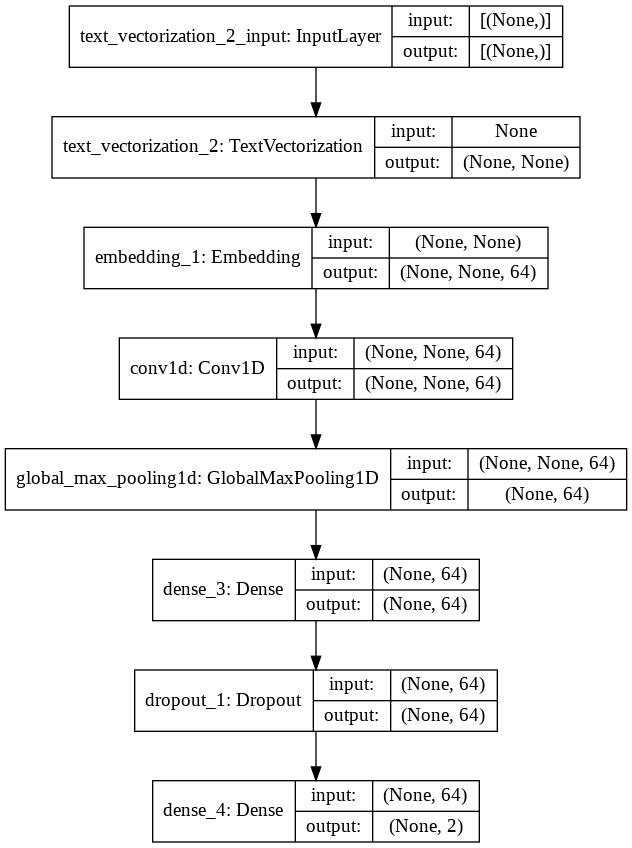

In [ ]:
keras.utils.plot_model(modelda, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dictda = historyda.history
history_dictda.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
historyda_df=pd.DataFrame(history_dictda)
historyda_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.470,0.763,0.341,0.847
1,0.291,0.879,0.312,0.869
2,0.214,0.917,0.318,0.868
3,0.144,0.949,0.353,0.862


In [ ]:
losses = historyda.history['loss']
accs = historyda.history['accuracy']
val_losses = historyda.history['val_loss']
val_accs = historyda.history['val_accuracy']
epochs = len(losses)

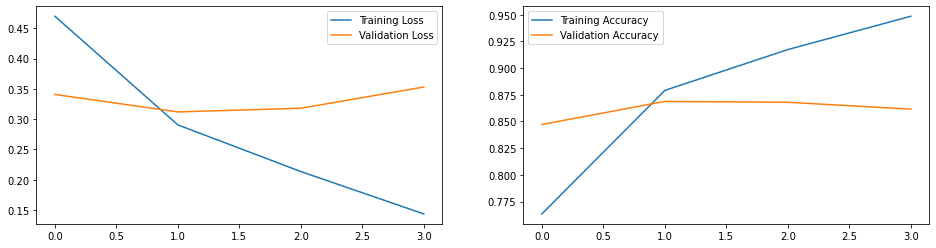

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = modelda.predict(test_dataset)

In [ ]:
preds.shape

(25000, 2)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['Positive','Negative']).T  #World','Sports','Business','Sci/Tech'
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Positive,25.91%,0.23%,98.79%,93.35%,0.13%,3.51%,0.06%,0.69%,34.86%,19.95%,99.99%,82.73%,2.97%,51.20%,12.98%
Negative,74.09%,99.77%,1.21%,6.65%,99.87%,96.49%,99.94%,99.31%,65.14%,80.05%,0.01%,17.27%,97.03%,48.80%,87.02%


# Experiment D-b - Conv1D with maxpooling without dropout

In [ ]:
modeldb = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True) 
                              ,tf.keras.layers.Conv1D(64, 2, activation='relu')
                              ,tf.keras.layers.GlobalMaxPooling1D()   #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
                              ,tf.keras.layers.Dense(64, activation='relu')
                              #,tf.keras.layers.Dropout(0.2)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
modeldb.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historydb = modeldb.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)]
                    )
Modeldb_Train_Time = datetime.datetime.now()-start
print(Modeldb_Train_Time)

Epoch 1/200
372/372 [==============================] - 13s 31ms/step - loss: 0.4456 - accuracy: 0.7910 - val_loss: 0.3621 - val_accuracy: 0.8312
Epoch 2/200
372/372 [==============================] - 7s 18ms/step - loss: 0.3022 - accuracy: 0.8702 - val_loss: 0.3337 - val_accuracy: 0.8520
Epoch 3/200
372/372 [==============================] - 6s 16ms/step - loss: 0.2515 - accuracy: 0.8963 - val_loss: 0.3228 - val_accuracy: 0.8568
Epoch 4/200
372/372 [==============================] - 6s 15ms/step - loss: 0.2068 - accuracy: 0.9178 - val_loss: 0.3478 - val_accuracy: 0.8504
Epoch 5/200
372/372 [==============================] - 6s 14ms/step - loss: 0.1736 - accuracy: 0.9331 - val_loss: 0.3722 - val_accuracy: 0.8592
Epoch 6/200
372/372 [==============================] - 6s 14ms/step - loss: 0.1398 - accuracy: 0.9483 - val_loss: 0.4030 - val_accuracy: 0.8552
Epoch 7/200
372/372 [==============================] - 5s 13ms/step - loss: 0.1078 - accuracy: 0.9630 - val_loss: 0.4643 - val_accuracy

In [ ]:
test_loss, test_acc = modeldb.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 4s 11ms/step - loss: 0.5253 - accuracy: 0.8557
Test Loss: 0.5252521634101868
Test Accuracy: 0.855679988861084


In [ ]:
history_dictdb = historydb.history
history_dictdb.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
historydb_df=pd.DataFrame(history_dictdb)
historydb_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
4,0.174,0.933,0.372,0.859
5,0.140,0.948,0.403,0.855
6,0.108,0.963,0.464,0.842
7,0.079,0.974,0.490,0.852
8,0.052,0.984,0.551,0.844


In [ ]:
modeldb.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_5 (TextVe (None, None)              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          8256      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 130       
Total params: 76,546
Trainable params: 76,546
Non-trainable params: 0
_________________________________________________

# Experiment D-c - Conv1D with Dropout

In [ ]:
modeldc = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True) 
                              ,tf.keras.layers.Conv1D(64, 5, activation='relu')
                              ,tf.keras.layers.Conv1D(64, 5, activation='relu')
                              ,tf.keras.layers.GlobalMaxPooling1D()   #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.25)
                              ,tf.keras.layers.Dense(10, activation='relu')
                              ,tf.keras.layers.Dense(1, activation='sigmoid')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
modeldc.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = datetime.datetime.now()
historydc = modeldc.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
Modeldc_Train_Time = datetime.datetime.now()-start
print(Modeldc_Train_Time)

Epoch 1/200
372/372 [==============================] - 11s 26ms/step - loss: 0.6952 - accuracy: 0.4983 - val_loss: 0.6933 - val_accuracy: 0.4696
Epoch 2/200
372/372 [==============================] - 8s 19ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5296
Epoch 3/200
372/372 [==============================] - 8s 19ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6939 - val_accuracy: 0.4704
Epoch 4/200
372/372 [==============================] - 8s 19ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6933 - val_accuracy: 0.4704
0:00:36.498505


In [ ]:
test_loss, test_acc = modeldc.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 5s 12ms/step - loss: 0.6931 - accuracy: 0.5000
Test Loss: 0.6931494474411011
Test Accuracy: 0.5


In [ ]:
history_dictdc = historydc.history
history_dictdc.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
historydc_df=pd.DataFrame(history_dictdc)
historydc_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.695,0.498,0.693,0.47
1,0.693,0.497,0.693,0.53
2,0.693,0.501,0.694,0.47
3,0.693,0.502,0.693,0.47


In [ ]:
modeldc.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_5 (TextVe (None, None)              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          20544     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          20544     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)              